# Hands-on Demo: Building a variational algorithm to compute ground and excited state of a quantum system

Jennifer Glick, IBM Quantum <br>

- Variational Quantum Eigensolver (VQE) for the ground state (Estimator primitive) [1]
- Varitional Quantum Deflation (VQD) to approximate first excited state (Estimator and Sampler primitive) [1]

[1] <br>
[2] [arxiv.1805.08138](arxiv.org/abs/1805.08138)









# Let's start by defining our quantum system (Hamiltonian).

We could imagine this Hamiltonian represents a molecule. We will find the ground and excited state of this Hamiltonian using VQE and VQD.

In [1]:
# define Hamiltonian

from qiskit.opflow import PauliSumOp

H = PauliSumOp.from_list([('XYII', 1), ('IYZI', 2), ('IIZX', 3), ('XIII', 4), ('IYII', 5)])
print(H)

1.0 * XYII
+ 2.0 * IYZI
+ 3.0 * IIZX
+ 4.0 * XIII
+ 5.0 * IYII


# A key ingredient to our approach is to define an ansatz for the state of this quantum system.

In [2]:
from qiskit.circuit.library import EfficientSU2

qc = EfficientSU2(num_qubits=H.num_qubits, reps=1)

qc_with_meas = qc.measure_all(inplace=False)
qc_with_meas.decompose().draw(fold=120)

┌──────────┐┌──────────┐                    ┌──────────┐┌───────────┐                           ░ ┌─┐         
   q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[4]) ├──■────■─────────■──┤ Ry(θ[8]) ├┤ Rz(θ[12]) ├───────────────────────────░─┤M├─────────
        ├──────────┤├──────────┤┌─┴─┐  │         │  └──────────┘└┬──────────┤┌───────────┐              ░ └╥┘┌─┐      
   q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[5]) ├┤ X ├──┼────■────┼───────■───────┤ Ry(θ[9]) ├┤ Rz(θ[13]) ├──────────────░──╫─┤M├──────
        ├──────────┤├──────────┤└───┘┌─┴─┐┌─┴─┐  │       │       └──────────┘├───────────┤┌───────────┐ ░  ║ └╥┘┌─┐   
   q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[6]) ├─────┤ X ├┤ X ├──┼───────┼────────────■──────┤ Ry(θ[10]) ├┤ Rz(θ[14]) ├─░──╫──╫─┤M├───
        ├──────────┤├──────────┤     └───┘└───┘┌─┴─┐   ┌─┴─┐        ┌─┴─┐    ├───────────┤├───────────┤ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ Ry(θ[3]) ├┤ Rz(θ[7]) ├───────────────┤ X ├───┤ X ├────────┤ X ├────┤ Ry(θ[11]) ├┤ Rz(θ[15]) ├─░──╫──╫──╫─┤M├
        └──────────┘└──────────┘               └───┘   └───┘        └───┘    └───────────┘└───────────┘ ░  ║  ║  ║ └╥┘
meas: 4/═══════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                           0  1  2  3

# Before we go on, let's recap basic useage of Sampler and Estimator primitives. We'll do this using the primitives from Qiskit Terra.

## First, let's sample from the ansatz circuit instantiated with random parameter values:

In [3]:
# define a set of (random) parameter values for the ansatz circuit
import numpy as np
theta = np.random.rand(qc.num_parameters)

In [4]:
# use the Sampler to sample from this circuit
from qiskit.primitives import Sampler

sampler = Sampler([qc_with_meas])
s_result = sampler([qc_with_meas], [theta])
print(s_result)

SamplerResult(quasi_dists=[{0: 0.2701106582272117, 1: 0.013652293834356854, 2: 0.013998818633940617, 3: 0.003668787639155591, 4: 0.005802996559538281, 5: 0.00035961525295109364, 6: 0.05388865466292148, 7: 0.0031959032057511222, 8: 0.37102026177024705, 9: 0.01751194473117983, 10: 0.05445798023399246, 11: 0.010605162901996546, 12: 0.051939444464084744, 13: 0.0025952227379158537, 14: 0.11607830133070776, 15: 0.011113953814049312}], metadata=[{}])


## Second, let's compute the expectation value of our Hamiltonian with this circuit ansatz:

In [5]:
from qiskit.primitives import Estimator

estimator = Estimator([qc], [H])
e_result = estimator([qc], [H], [theta])
print(e_result)

EstimatorResult(values=array([3.98321765]), metadata=[{}])


# Okay, now that we've reviewed the primitives, let's go back to our original problem. 

We'll start by doing an exact calculation of the ground state and first excited state of our Hamiltonian. This will give us a "classical" baseline for what to expect with the quantum algorithms.

In [6]:
from qiskit.algorithms import NumPyEigensolver

exact_solver = NumPyEigensolver(k=2) # find the first two '2' eigenvalues
exact_result = exact_solver.compute_eigenvalues(H)
print(exact_result.eigenvalues)

[-13.  -9.]


# The first thing we'll do with the quantum approach is build an algorithm to compute the *ground state*. 

We'll use the workhorse algorithm called "variational quantum eigensolver". And, we'll do it in two ways: custom and using Qiskit interfaces.

## Approach 1. Build a custom VQE

We'll need a few ingredients:

- a classical optimizer (updates the parameters of our circuit ansatz)
- define an objective function to optimize (minimize)

In [7]:
# instantiate optimizer

from qiskit.algorithms.optimizers import SPSA
optimizer = SPSA(maxiter=500)

In [8]:
# define objective as expectation value of Hamiltonian with circuit ansatz

objective = lambda x: estimator([qc], [H], [x]).values[0]

In [9]:
# define initial values for our circuit parameters
x0 = np.random.rand(qc.num_parameters)

# minimize the objective function
result = optimizer.minimize(objective, x0=x0)

# store ground state parameters for later
ground_state_params = result.x

# print the resulting ground state energy
print(result.fun)

-12.999592037798955


... remember the exact result was -13, so we got pretty close.

## Approach 2: Build a VQE from Qiskit interfaces

In this approach, we will implement Qiskit's `MinimumEigensolver` interface to reuse custom algorithm in Qiskit Applications stack.

In [10]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

In [11]:
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operator, aux_operators=None):
                
        # define objective
        def objective(x):
            e_job = self._estimator([self._circuit], [operator], [x])
            value = e_job.values[0]
            if self._callback:
                self._callback(value)
            return value
            
        # run optimization
        x0 = np.random.rand(self._circuit.num_parameters)
        res = self._optimizer.minimize(objective, x0=x0)
        
        # populate results
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [12]:
# run the custom VQE function
custom_vqe = CustomVQE(estimator, qc, optimizer)
result = custom_vqe.compute_minimum_eigenvalue(H)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 1000,
    'eigenstate': None,
    'eigenvalue': -12.594739178931297,
    'optimal_parameters': array([-2.48269156e+00,  3.81733512e+00,  1.67894077e+00, -1.57834751e+00,
        1.97448787e+00,  3.18116397e-01,  1.72690012e-01, -1.40783565e-02,
        1.92415443e+00, -7.94396356e-01, -9.35285186e-02,  2.90058525e-03,
       -4.73181349e-01, -7.90030208e-01,  1.74394204e+00, -1.98196970e-02]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_time': None}


# Now that we've solved for the ground state, let's build a quantum algorithm to find the *excited* state.

To do this, we'll need a function to evaluate fidelity between the ground state and our guess of the excited state. This is used as a penalty to the original objective function (energy).

## Step 1: Define a custom state Fidelity function that uses the Sampler primitive

In [13]:
from qiskit.circuit import ParameterVector

class Fidelity():
    
    def __init__(self, sampler):
        """ Instantiate fidelity estimator. """
        #self._sampler = sampler
        
    def run(self, circuit_1, circuit_2, param_values_1, param_values_2):
        """ Estimate fidelity between two states defined by given parameter values."""
        
        # prepare circuit
        circuit_1_ = circuit_1.remove_final_measurements(inplace=False)        
        circuit_2_ = circuit_2.remove_final_measurements(inplace=False)
        x = ParameterVector("x", circuit_1_.num_parameters)
        y = ParameterVector("y", circuit_2_.num_parameters)
        circuit = circuit_1_.assign_parameters(x).compose(circuit_2_.inverse().assign_parameters(y))
        circuit.measure_all()
        
        # run circuit and get probabilities
        param_values = np.append(param_values_1, param_values_2)
        sampler = Sampler([circuit])
        s_job = sampler([circuit], [param_values])
        probabilities = s_job.quasi_dists[0]

        # estimate fidelity: |<0|U_1^dag U_2|0>|^2 clipped to [0, 1]
        fidelity = np.minimum(1.0, np.maximum(0.0, probabilities.get(0, 0.0)))
        return fidelity

### Let's see what this Fidelity looks between the ground state and a range excited state values.

In [14]:
# instantiate fidelity
fidelity = Fidelity(sampler)

# interpolation between parameters
ts = np.linspace(0, 1)
fidelities = [fidelity.run(qc, qc, ground_state_params, ground_state_params + t*theta) for t in ts]

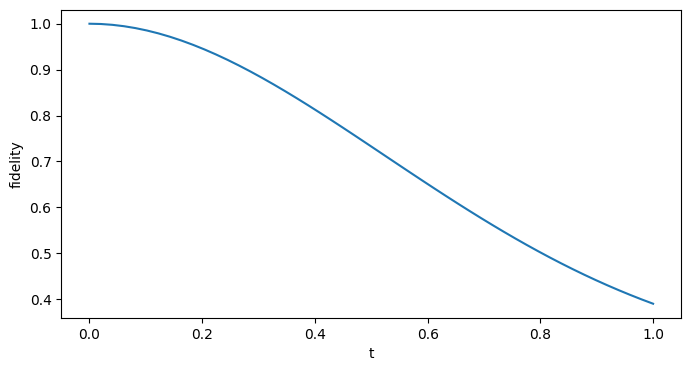

In [15]:
# As we crank up the circuit values, the excited state gets "further" from the ground state 
# (fidelity goes down)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(ts, fidelities)
plt.xlabel('t')
plt.ylabel('fidelity')
plt.show()

## Step 2: Define a Variational Quantum Deflation (VQD) algorithm

Recall that the exact solution gave us an excited state of `-9.0`

### First, we define an objective function for VQD.

Notice that we'll be using the Estimator for the original objective (expectation value of Hamiltonian) PLUS the Sampler to add in the fidelity term. We'll need to set a penalty value for this fidelity contribution.

In [16]:
# set penalty weight for overlap term
penalty = 25

# define objective for VQD
vqd_objective = lambda x: objective(x) + penalty*fidelity.run(qc, qc, ground_state_params, x)

### Next, we minimize our VQD objective

In [17]:
# run optimization to get first excited state
result = optimizer.minimize(vqd_objective, ground_state_params)
print(result)

{   'fun': -8.881647989785796,
    'jac': None,
    'nfev': 1000,
    'nit': 500,
    'njev': None,
    'x': array([-12.55853952,  21.94136364,  12.5190952 ,   2.1198933 ,
        20.95442144,  25.66002311,  -4.67002992, -21.71503506,
         4.57094725,  12.59195524,  36.03942733,  22.75801307,
        28.31739971,  18.67793003, -20.44965165, -15.49843998])}


### Now that we've minimized the objective, we get a set of optimized circuit parameters. Let's plug these into the Estimator and get the corresponding (excited state) energy.

In [18]:
# determine energy
e_job = estimator([qc], [H], [result.x])
print(e_job)

EstimatorResult(values=array([-8.88516738]), metadata=[{}])


Recall that the exact solution is -9. We got pretty close!

### Let's see what the overlap (fidelity) of this excited state is with the ground state.

In [19]:
fid = fidelity.run(qc, qc, result.x, ground_state_params);
print(fid)

0.000140775667099545


## Just like we saw with VQE, we can build VQD from Qiskit's interfaces.

Implement Qiskit's `Eigensolver` interface to reuse custom algorithm in Qiskit Applications stack.

In [20]:
from qiskit.algorithms import Eigensolver, EigensolverResult

In [21]:
class VQD(Eigensolver):
    
    def __init__(self, estimator, fidelity, circuit, optimizer, penalty=25, callback=None):
        
        # self._estimator = estimator
        self._fidelity = fidelity
        self._circuit = circuit
        self._optimizer = optimizer
        self._penalty = penalty
        self._callback = callback
        
    def compute_eigenvalues(self, operator, aux_operators=None):
                
        # compute ground state
        estimator = Estimator([self._circuit], [operator])
        energy = lambda x: estimator([self._circuit], [operator], [x]).values[0]
        x0 = np.random.rand(self._circuit.num_parameters)
        res_1 = self._optimizer.minimize(energy, x0)

        # compute first excited states
        overlap = lambda x: self._fidelity.run(self._circuit, self._circuit, res_1.x, x)
        def objective(x):
            value = energy(x) + self._penalty * overlap(x)
            if self._callback:
                self._callback(value)
            return value
        res_2 = self._optimizer.minimize(objective, res_1.x)
            
        # populate results
        result = EigensolverResult()
        result.eigenvalues = [estimator([self._circuit], [operator], [res_1.x]),
                              estimator([self._circuit], [operator], [res_2.x])]
        return result        

In [22]:
vqd = VQD(estimator, fidelity, qc, optimizer=SPSA(maxiter=1000))
result = vqd.compute_eigenvalues(H)
print(result)

{   'aux_operator_eigenvalues': None,
    'eigenstates': None,
    'eigenvalues': [   EstimatorResult(values=array([-11.05846049]), metadata=[{}]),
                       EstimatorResult(values=array([-11.13702362]), metadata=[{}])]}


## And, finally, let's pull everything together and use the Qiskit Runtime Primitives with Sessions.

In [23]:
from qiskit_ibm_runtime import (Session, Options, QiskitRuntimeService,
                                Sampler as RuntimeSampler, 
                                Estimator as RuntimeEstimator)

In [24]:
service = QiskitRuntimeService(channel='ibm_quantum')

In [26]:

from qiskit.algorithms.optimizers import COBYLA
optimizer = COBYLA(maxiter=400)

with Session(service=service, backend='ibmq_qasm_simulator') as session:

    # prepare primitives
    rt_estimator = RuntimeEstimator(session=session)
    rt_sampler = RuntimeSampler(session=session)
    rt_fidelity = Fidelity(rt_sampler)

    # set up algorithm    
    rt_vqd = VQD(rt_estimator, rt_fidelity, qc, optimizer)
    
    # run algorithm
    result = rt_vqd.compute_eigenvalues(H)
    print(result)    

{   'aux_operator_eigenvalues': None,
    'eigenstates': None,
    'eigenvalues': [   EstimatorResult(values=array([-12.99999527]), metadata=[{}]),
                       EstimatorResult(values=array([-6.99950004]), metadata=[{}])]}


In [27]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.7.0rc1'

In [29]:
from qiskit.tools.jupyter import *

%qiskit_version_table
%qiskit_copyright